# DL PROJECT

## DIABETIC RETINOPATHY DETECTION

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import array_to_img
# from sklearn.model_selection import train_test_split
# from PIL import Image
# import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

# from tqdm import tqdm, tqdm_notebook
# from colorama import Fore
# import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
# import time
# from sklearn.decomposition import PCA
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# import lightgbm as lgb
# import xgboost as xgb
# !pip install livelossplot
# import livelossplot
# from livelossplot import PlotLossesKeras
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")

All modules have been imported


In [ ]:
# copy the weights and configurations for the pre-trained models
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

mkdir: cannot create directory ‘/root/.keras’: File exists
cp: cannot stat '../input/keras-pretrained-models/*notop*': No such file or directory
cp: cannot stat '../input/keras-pretrained-models/imagenet_class_index.json': No such file or directory


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob

%matplotlib inline 

#### Data set of 10000 images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
base_image_dir = os.path.join('.', '/content/drive/MyDrive/Sample_data_10000')
df = pd.read_csv(os.path.join('/content/drive/MyDrive/trainLabels_cropped.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset

df = df[df['exists']]
print(df[df['exists']])
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True)#shuffle dataframe
df['level'] = df['level'].astype(str)
df.head(10)

       Unnamed: 0  Unnamed: 0.1        image  level  \
0               0             0      10_left      0   
1               1             1     10_right      0   
2               2             2      13_left      0   
3               3             3     13_right      0   
4               4             4      15_left      1   
...           ...           ...          ...    ...   
10183       10183         10190   12838_left      0   
10184       10184         10191  12838_right      0   
10185       10185         10192   12839_left      2   
10186       10186         10193  12839_right      2   
10187       10187         10194   12842_left      0   

                                                    path  exists  
0      /content/drive/MyDrive/Sample_data_10000/10_le...    True  
1      /content/drive/MyDrive/Sample_data_10000/10_ri...    True  
2      /content/drive/MyDrive/Sample_data_10000/13_le...    True  
3      /content/drive/MyDrive/Sample_data_10000/13_ri...    True  
4   

,Unnamed: 0,Unnamed: 0.1,level,path
0,669,670,2,/content/drive/MyDrive/Sample_data_10000/818_l...
1,5478,5482,0,/content/drive/MyDrive/Sample_data_10000/6888_...
2,4161,4165,2,/content/drive/MyDrive/Sample_data_10000/5213_...
3,3558,3562,2,/content/drive/MyDrive/Sample_data_10000/4464_...
4,1462,1464,0,/content/drive/MyDrive/Sample_data_10000/1832_...
5,3212,3216,0,/content/drive/MyDrive/Sample_data_10000/3994_...
6,5358,5362,0,/content/drive/MyDrive/Sample_data_10000/6740_...
7,10076,10083,2,/content/drive/MyDrive/Sample_data_10000/12699...
8,7506,7510,0,/content/drive/MyDrive/Sample_data_10000/9469_...
9,2957,2960,0,/content/drive/MyDrive/Sample_data_10000/3660_...


## PREPROCESSING

## Distribution of Eye and Severity

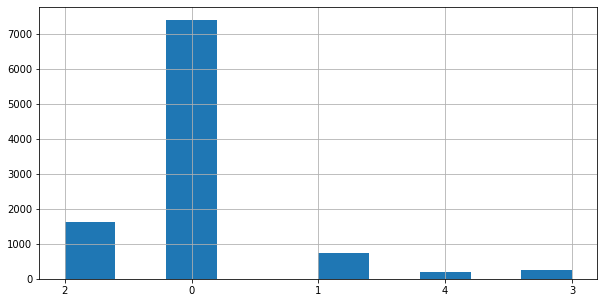

In [ ]:
df['level'].hist(figsize = (10, 5))

In [ ]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

## Split Data into Training and Validation

2038

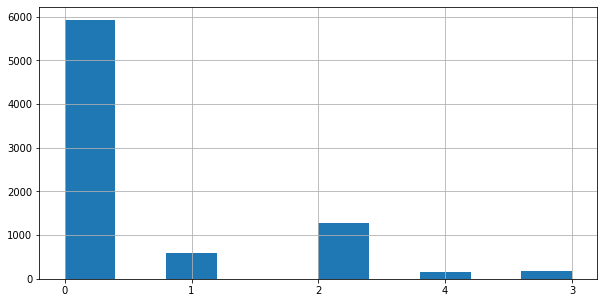

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set
train_df['level'].hist(figsize = (10, 5))
len(val_df)

## Balancing the distribution in the Training set

New Data Size: 29640 Old Size: 8150


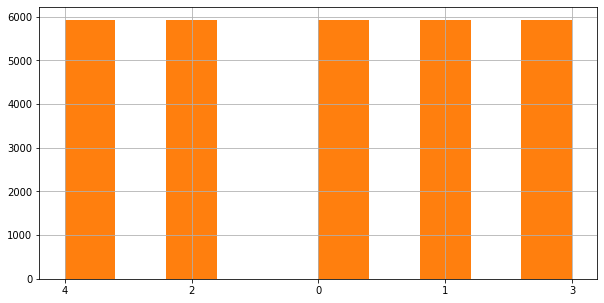

In [ ]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [ ]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

31678

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip = True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

In [ ]:
x_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=".",
        x_col="path",
        y_col="level",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')
x_test = test_datagen.flow_from_dataframe(
        val_df,
        x_col="path",
        y_col="level",
        directory=".",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 29640 validated image filenames belonging to 5 classes.
Found 2038 validated image filenames belonging to 5 classes.


In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Image Generators

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
t_x, t_y = next(x_train)

In [ ]:
def create_CNN_model(model):
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(264,264,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

# InceptionRestNet V2 and InceptionRestNet V3

In [ ]:
from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = 2048
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 6, 6, 2048)   21802784    ['input_1[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 6, 6, 2048)  8192        ['inception_v3[0][0]']           
 ormalization)                                                                                    
                             

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 6, 6, 2048)   21802784    ['input_1[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 6, 6, 2048)  8192        ['inception_v3[0][0]']           
 ormalization)                                                                                    
                                                                                              

In [ ]:
filepath = "dr-detector.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_top2_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

earlystop = EarlyStopping(monitor='val_categorical_accuracy',
                          verbose=1, 
                          min_delta=0, 
                          patience=15, 
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              verbose=1,
                              factor=0.2, 
                              patience=6, 
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0.001)


callbacks = [checkpoint, earlystop, reduce_lr]

In [ ]:
history = model.fit(
        x_train,
        steps_per_epoch=x_train.samples // 64,
        epochs=5,
        validation_data=x_test,
        validation_steps=x_test.samples // 64,
        callbacks=callbacks)
model.save_weights("dr_messidor.h5")

Epoch 1/5
463/463 [==============================] - ETA: 0s - loss: 1.2693 - categorical_accuracy: 0.4478 - top_2_accuracy: 0.6954

463/463 [==============================] - 1656s 4s/step - loss: 1.2693 - categorical_accuracy: 0.4478 - top_2_accuracy: 0.6954 - val_loss: 1.3496 - val_categorical_accuracy: 0.2974 - val_top_2_accuracy: 0.6784 - lr: 0.0010
Epoch 2/5
463/463 [==============================] - ETA: 0s - loss: 1.0612 - categorical_accuracy: 0.5389 - top_2_accuracy: 0.7735

463/463 [==============================] - 748s 2s/step - loss: 1.0612 - categorical_accuracy: 0.5389 - top_2_accuracy: 0.7735 - val_loss: 1.3031 - val_categorical_accuracy: 0.2964 - val_top_2_accuracy: 0.7137 - lr: 0.0010
Epoch 3/5
463/463 [==============================] - ETA: 0s - loss: 0.9589 - categorical_accuracy: 0.5869 - top_2_accuracy: 0.8068

463/463 [==============================] - 558s 1s/step - loss: 0.9589 - categorical_accuracy: 0.5869 - top_2_accuracy: 0.8068 - val_loss: 1.2503 - val_categorical_accuracy: 0.3810 - val_top_2_accuracy: 0.7530 - lr: 0.0010
Epoch 4/5
463/463 [==============================] - ETA: 0s - loss: 0.8873 - categorical_accuracy: 0.6149 - top_2_accuracy: 0.8274

463/463 [==============================] - 484s 1s/step - loss: 0.8873 - categorical_accuracy: 0.6149 - top_2_accuracy: 0.8274 - val_loss: 1.2060 - val_categorical_accuracy: 0.4224 - val_top_2_accuracy: 0.7913 - lr: 0.0010
Epoch 5/5
463/463 [==============================] - ETA: 0s - loss: 0.8494 - categorical_accuracy: 0.6318 - top_2_accuracy: 0.8425

463/463 [==============================] - 455s 983ms/step - loss: 0.8494 - categorical_accuracy: 0.6318 - top_2_accuracy: 0.8425 - val_loss: 1.2473 - val_categorical_accuracy: 0.3518 - val_top_2_accuracy: 0.7833 - lr: 0.0010


In [ ]:
train_score = model.evaluate(x_train)
test_score = model.evaluate(x_test)

64/64 [==============================] - 47s 741ms/step - loss: 1.2464 - categorical_accuracy: 0.3611 - top_2_accuracy: 0.7753
Final training accuracy = 71.51 , validation accuracy = 36.11
Final training loss = 0.67 , validation loss = 1.25


In [ ]:
print("Final training categorical accuracy = {:.2f} , Final validation categorical accuracy = {:.2f}".format(train_score[1]*100, test_score[1]*100))
print("Final training Top 2 accuracy = {:.2f} , Final validation Top 2 accuracy = {:.2f}".format(train_score[2]*100, test_score[2]*100))
print("Final training loss = {:.2f} , Final validation loss = {:.2f}".format(train_score[0], test_score[0]))

Final training categorical accuracy = 71.51 , Final validation categorical accuracy = 36.11
Final training Top 2 accuracy = 89.65 , Final validation Top 2 accuracy = 77.53
Final training loss = 0.67 , Final validation loss = 1.25


In [ ]:
history.history

{'loss': [1.2693049907684326,
  1.0611631870269775,
  0.9588732719421387,
  0.8873332142829895,
  0.8493701219558716],
 'categorical_accuracy': [0.447809636592865,
  0.5388723611831665,
  0.5868712663650513,
  0.6149269938468933,
  0.6318169832229614],
 'top_2_accuracy': [0.6953758597373962,
  0.7735262513160706,
  0.8067874312400818,
  0.8274067044258118,
  0.8424676060676575],
 'val_loss': [1.3496137857437134,
  1.303057074546814,
  1.250259280204773,
  1.2060410976409912,
  1.2473151683807373],
 'val_categorical_accuracy': [0.2973790466785431,
  0.2963709533214569,
  0.38104838132858276,
  0.4223790466785431,
  0.35181450843811035],
 'val_top_2_accuracy': [0.6784273982048035,
  0.7137096524238586,
  0.7530242204666138,
  0.7913306355476379,
  0.7832661271095276],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001]}

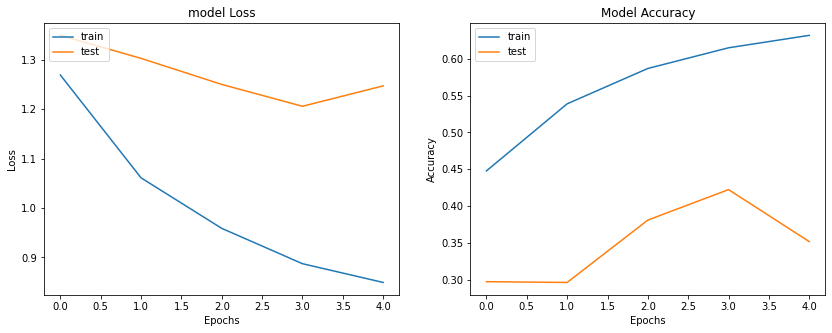

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

927/927 [==============================] - 796s 858ms/step
Confusion Matrix
[[1042 1318 1164 1229 1175]
 [ 983 1240 1162 1260 1283]
 [ 953 1298 1180 1222 1275]
 [ 979 1280 1150 1302 1217]
 [ 961 1263 1127 1265 1312]]
Classification Report
              precision    recall  f1-score   support

           0       0.21      0.18      0.19      5928
           1       0.19      0.21      0.20      5928
           2       0.20      0.20      0.20      5928
           3       0.21      0.22      0.21      5928
           4       0.21      0.22      0.22      5928

    accuracy                           0.20     29640
   macro avg       0.21      0.20      0.20     29640
weighted avg       0.21      0.20      0.20     29640



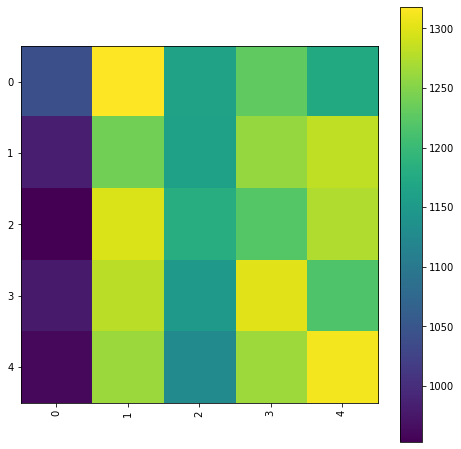

In [ ]:
y_pred = model.predict(x_train)
y_pred = np.argmax(y_pred, axis=1)
class_labels = x_test.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(x_train.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(x_train.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)